# Training an Agent to play Super Mario
---

In this exercise you are going to train a Q-Learning agent on the ```gym-marioai``` domain.  
gym_marioai provides a python interface to interact with the MarioAI engine in a comfortable way. The engine itself is implemented in java, and the ```.jar``` of the engine needs to be started separately.  

### Installation
Requirements: Java 8 runtime environment, python 3.?  
You will be provided with both the .jar and the gym-marioai python package.

### Running the MarioAI server:
navigate to the folder containing ```marioai-server.jar```, then run the following:  
```java -jar ./marioai-server.jar```

### Alternatively:
To run the server, run the following cell. It will launch the jar containing the Java engine.

In [2]:
from subprocess import Popen
server_process = Popen(
    ['java', '-jar', '../marioai-server/target/marioai-server-0.1-jar-with-dependencies.jar'])


In [4]:
# to run the jar version which is included in the gym_marioai python package:
# (needs to be updated when changes to the sources are made)

#from gym_marioai import server
#server_process = server.run_server_in_background(8080)

### Closing the MarioAI server: (this also happens automatically by closing the render window)
To kill the server process comment in the following cell and run it. Do not do this yet though ;).

In [2]:
#server_process.kill()

In [3]:
import numpy as np
import gym
import gym_marioai

from qlearner import QLearner

---
# Task:
In this exercise, we want to examine how we can teach an agent specific behavior by shaping the reward function.
An implementation of the $Q(\lambda)$ learning algorithm is provided, so you don't need to implement it yourself.  
Specifically, we want to teach an agent to overcome a gap in the environment. But we do not want the agent to just finish the level afterwards, instead it should repeatedly jump back and forth across the gap and thereby collect the reward every time it manages to jump from left to right.  
As such, the objective of this task is to maximize the number of cliff jumps per episode.  

Can you think of possible problems that may occur in the default setting?

### Training Parameters

In [4]:
# constant, should not be changed
n_episodes = 5000
alpha = 0.1
gamma = 0.99
lmbda = 0.75
epsilon_start = 0.5
epsilon_end = 0.01
epsilon_decay_length = n_episodes / 2
decay_step = (epsilon_end - epsilon_start) / epsilon_decay_length

#level = 'oneCliffLevel'
#path = gym_marioai.levels.one_cliff_level
#rf_width = 20
#rf_height = 10

# can be finetuned
# (TODO these are working parameters, change the initial values for the exercise)
# the trace parameter is the number of consecutive observations that are used as 
# state information (k-th order history)
trace = 2

# reward function params
prog = 1
timestep = -1
cliff = 1000
win = -10
dead = -10

reward_settings = gym_marioai.RewardSettings(
    progress=prog, timestep=timestep, cliff=cliff, win=win, dead=dead)

In [5]:
###################################
#       environment setup
###################################
env = gym.make('Marioai-v1', render=False,
               #level_path=path,
               reward_settings=reward_settings,
               #compact_observation=True,
               trace_length=trace,
               #rf_width=rf_width, rf_height=rf_height)
              )

In [6]:
##################################
# Training Loop
##################################
def train(env, agent):
    try:
        all_rewards = np.zeros([n_episodes])
        all_wins = np.zeros([n_episodes])
        all_steps = np.zeros([n_episodes])
        all_jumps = np.zeros([n_episodes])
        
        for e in range(n_episodes):
            done = False
            info = {}
            total_reward = 0
            steps = 0
            epsilon = max(epsilon_end, epsilon_start + e * decay_step)
            
            state = env.reset()
            action = agent.choose_action(state, epsilon)
            
            while not done:
                next_state, reward, done, info = env.step(action)
                total_reward += reward
                next_action = agent.choose_action(next_state, epsilon)
                agent.learn(state, action, reward, next_state, next_action)
                
                state, action = next_state, next_action
                steps += 1
                
            # store statistics for later use
            all_rewards[e] = total_reward
            all_wins[e] = 1 if info['win'] else 0
            all_steps[e] = info['steps']
            all_jumps[e] = info['cliff_jumps']

            if e % 100 == 99:
                # print training statistics of the last 100 episodes
                avg_reward = all_rewards[e-99:e+1].mean()
                avg_wins = all_wins[e-99:e+1].mean()
                avg_steps = all_steps[e-99:e+1].mean()
                avg_jumps = all_jumps[e-99:e+1].mean()
                
                print(f'Episode: {e+1} Eps: {epsilon:.3f}', f'Avg Reward: {avg_reward:>4.2f}',
                    f'Avg steps: {avg_steps:>4.2f}', f'Win% : {avg_wins:3.2f}',
                    f'Cliff jumps: {avg_jumps:.1f}', f'States seen: {agent.Q.num_states}    ', end='\r')
        print()        
        return all_rewards, all_wins, all_steps, all_jumps
    except KeyboardInterrupt:
        pass

In [7]:
#agent = QLearner(env, alpha, gamma, lmbda)
#rewards, wins, steps, jumps = train(env, agent)

Episode: 5000 Eps: 0.010 Avg Reward: 3617.15 Avg steps: 324.48 Win% : 0.03 Cliff jumps: 3.9 States seen: 1149    


In [8]:
# conduct multiple runs to plot a mean curve later
n_runs = 5
stats = []

for i in range(n_runs):
    agent = QLearner(env, alpha, gamma, lmbda)
    rewards, wins, steps, jumps = train(env, agent)
    
    print(f'training {i} finished.')
    stats.append(jumps)

Episode: 5000 Eps: 0.010 Avg Reward: 9227.23 Avg steps: 448.00 Win% : 0.18 Cliff jumps: 9.6 States seen: 1143      
training 0 finished.
Episode: 5000 Eps: 0.010 Avg Reward: 904.83 Avg steps: 120.65 Win% : 0.96 Cliff jumps: 1.0 States seen: 1118    
training 1 finished.
Episode: 5000 Eps: 0.010 Avg Reward: 4884.48 Avg steps: 323.31 Win% : 0.00 Cliff jumps: 5.2 States seen: 1117    
training 2 finished.
Episode: 5000 Eps: 0.010 Avg Reward: 721.23 Avg steps: 296.28 Win% : 0.06 Cliff jumps: 1.0 States seen: 1142    
training 3 finished.
Episode: 5000 Eps: 0.010 Avg Reward: 927.80 Avg steps: 128.80 Win% : 0.99 Cliff jumps: 1.0 States seen: 1118    
training 4 finished.


---
### Optional: Save the model for later use

In [ ]:
#agent = QLearner(env, alpha, gamma, lmbda)
#rewards, wins, steps, jumps = train(env, agent)

In [ ]:
agent.save('./test_model.p')

---
## Plot the results

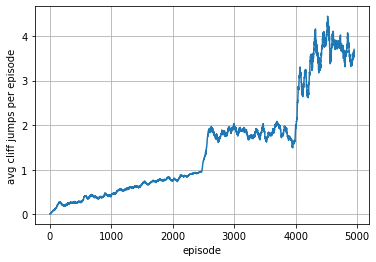

In [9]:
import matplotlib.pyplot as plt

def smoothen(arr, w):
    cumsum_vec = np.cumsum(np.insert(arr, 0, 0)) 
    ma_vec = (cumsum_vec[w:] - cumsum_vec[:-w]) / w
    return ma_vec

stats = np.array(stats)

mean = stats.mean(0)
# std = all_jumps.std(0)
# plt.fill_between(np.arange(0, n_episodes), mean-std, mean+std)

plt.plot(smoothen(mean, 50))
plt.xlabel("episode")
plt.ylabel("avg cliff jumps per episode")
plt.grid()
#plt.savefig('./experiment_results/traces_1-3.png', bbox_inches='tight')
plt.show()


---
## Replay
You can either use the agent model which is kept in memory, or load a previous model from disk:

In [ ]:
# agent.load('./path/to/test_model.p')

In [8]:
for e in range(5):
    done = False
    info = {}
    total_reward = 0
    steps = 0
    state = env.reset(render=True)

    while not done:
        action = agent.choose_action(state, epsilon=0)
        state, reward, done, info = env.step(action)
        total_reward += reward
        steps += 1

RuntimeError: socket connection broken